# Pipeline

### Data input

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Importing the dataset
df = pd.read_csv('creditcard.csv')
df = df.drop(['Time'], axis=1)
df.reset_index(drop=True, inplace=True)

### Data preprocessing

### Model hyperparameter tuning

In [43]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer 

pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(),
    LogisticRegression()
)

params_grid = {
    'selectkbest__k': [5, 15, 25],
    'logisticregression__C': [ 0.1, 1, 5, 10, 25, 50, 100],
    'logisticregression__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [100, 200, 500],
}

As the data set in very unbalanced, we will use the F1 score as the metric to evaluate the model performance.

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Split data
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis=1), df['Class'], test_size=0.2, random_state=42)

# Train model
grid = RandomizedSearchCV(pipeline, params_grid, scoring=make_scorer(f1_score, average='macro'), cv=5, n_jobs=-1, n_iter=10, verbose=2).fit(X_train, y_train)
model = grid.best_estimator_

# Evaluate model
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis=1), df['Class'], test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict_proba(X_test)[:,-1] > 0.5)
y_test = pd.DataFrame(y_test)
f1_score_ = f1_score(y_test, y_pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [45]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, target_names=['Not Fraud', 'Fraud'], digits=4))

,Not Fraud,Fraud,accuracy,macro avg,weighted avg
precision,0.999262,0.861538,0.999105,0.930400,0.999025
recall,0.999842,0.571429,0.999105,0.785635,0.999105
f1-score,0.999552,0.687117,0.999105,0.843334,0.999014
support,56864.000000,98.000000,0.999105,56962.000000,56962.000000


For LogisticRegression, we manage to have an average f1 score of 0.84.

In [46]:
import xgboost as xgb

pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(),
    xgb.XGBClassifier(early_stopping_rounds=2, tree_method='hist')
)

params_grid = {
    'selectkbest__k': [5, 15, 25],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.05],
}

In [47]:
# Split data
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, validation = train_test_split(train, test_size=0.2)
Dtrain = xgb.DMatrix(train.drop(['Class'], axis=1), label=train['Class'])
Dval = xgb.DMatrix(validation.drop(['Class'], axis=1), label=validation['Class'])
Dtest = xgb.DMatrix(test.drop(['Class'], axis=1), label=test['Class'])

search_cv = []

for eta in [0.05, 0.1, 0.5]:
    for mdepth in [3, 7]:
        for tree_method in ['hist', 'approx', 'auto']:
            # Train model
            param = {
                'max_depth': mdepth,
                'eta': eta,
                'objective': 'binary:logistic',
                'tree_method': tree_method,
            }

            # Evaluate model
            num_round = 100
            eval_list = [(Dval, 'eval'), (Dtrain, 'train')]
            bst = xgb.train(param, Dtrain, num_round, eval_list, early_stopping_rounds=5, verbose_eval=10)

            # Model evaluation
            y_pred = pd.DataFrame(bst.predict(Dval) > 0.5)
            y_val = pd.DataFrame(validation['Class'])
            search_cv.append([param, f1_score(y_val, y_pred)])

c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future 

[0]	eval-logloss:0.12364	train-logloss:0.12442
[10]	eval-logloss:0.07350	train-logloss:0.07384
[20]	eval-logloss:0.04465	train-logloss:0.04485
[30]	eval-logloss:0.02767	train-logloss:0.02780
[40]	eval-logloss:0.01758	train-logloss:0.01766
[50]	eval-logloss:0.01155	train-logloss:0.01159
[60]	eval-logloss:0.00793	train-logloss:0.00793
[70]	eval-logloss:0.00578	train-logloss:0.00573
[80]	eval-logloss:0.00453	train-logloss:0.00440
[90]	eval-logloss:0.00378	train-logloss:0.00358
[99]	eval-logloss:0.00338	train-logloss:0.00311


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.12363	train-logloss:0.12441
[10]	eval-logloss:0.07352	train-logloss:0.07383
[20]	eval-logloss:0.04465	train-logloss:0.04481
[30]	eval-logloss:0.02766	train-logloss:0.02773
[40]	eval-logloss:0.01755	train-logloss:0.01756
[50]	eval-logloss:0.01151	train-logloss:0.01148
[60]	eval-logloss:0.00789	train-logloss:0.00782
[70]	eval-logloss:0.00577	train-logloss:0.00561
[80]	eval-logloss:0.00452	train-logloss:0.00428
[90]	eval-logloss:0.00379	train-logloss:0.00347
[99]	eval-logloss:0.00340	train-logloss:0.00300


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.12364	train-logloss:0.12442
[10]	eval-logloss:0.07350	train-logloss:0.07384
[20]	eval-logloss:0.04465	train-logloss:0.04485
[30]	eval-logloss:0.02767	train-logloss:0.02780
[40]	eval-logloss:0.01758	train-logloss:0.01766
[50]	eval-logloss:0.01155	train-logloss:0.01159
[60]	eval-logloss:0.00793	train-logloss:0.00793
[70]	eval-logloss:0.00578	train-logloss:0.00573
[80]	eval-logloss:0.00453	train-logloss:0.00440
[90]	eval-logloss:0.00378	train-logloss:0.00358
[99]	eval-logloss:0.00338	train-logloss:0.00311
[0]	eval-logloss:0.12362	train-logloss:0.12440
[10]	eval-logloss:0.07342	train-logloss:0.07367


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.04451	train-logloss:0.04458
[30]	eval-logloss:0.02748	train-logloss:0.02736
[40]	eval-logloss:0.01735	train-logloss:0.01707
[50]	eval-logloss:0.01130	train-logloss:0.01084
[60]	eval-logloss:0.00771	train-logloss:0.00706
[70]	eval-logloss:0.00557	train-logloss:0.00473
[80]	eval-logloss:0.00427	train-logloss:0.00327
[90]	eval-logloss:0.00352	train-logloss:0.00236
[99]	eval-logloss:0.00313	train-logloss:0.00182
[0]	eval-logloss:0.12363	train-logloss:0.12439


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07343	train-logloss:0.07366
[20]	eval-logloss:0.04453	train-logloss:0.04456
[30]	eval-logloss:0.02752	train-logloss:0.02736
[40]	eval-logloss:0.01740	train-logloss:0.01706
[50]	eval-logloss:0.01137	train-logloss:0.01085
[60]	eval-logloss:0.00779	train-logloss:0.00706
[70]	eval-logloss:0.00565	train-logloss:0.00473
[80]	eval-logloss:0.00438	train-logloss:0.00328
[90]	eval-logloss:0.00362	train-logloss:0.00237
[99]	eval-logloss:0.00322	train-logloss:0.00181


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.12362	train-logloss:0.12440
[10]	eval-logloss:0.07342	train-logloss:0.07367
[20]	eval-logloss:0.04451	train-logloss:0.04458
[30]	eval-logloss:0.02748	train-logloss:0.02736
[40]	eval-logloss:0.01735	train-logloss:0.01707
[50]	eval-logloss:0.01130	train-logloss:0.01084
[60]	eval-logloss:0.00771	train-logloss:0.00706
[70]	eval-logloss:0.00557	train-logloss:0.00473
[80]	eval-logloss:0.00427	train-logloss:0.00327
[90]	eval-logloss:0.00352	train-logloss:0.00236
[99]	eval-logloss:0.00313	train-logloss:0.00182
[0]	eval-logloss:0.11712	train-logloss:0.11776


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04242	train-logloss:0.04259
[20]	eval-logloss:0.01677	train-logloss:0.01684
[30]	eval-logloss:0.00763	train-logloss:0.00763
[40]	eval-logloss:0.00442	train-logloss:0.00428
[50]	eval-logloss:0.00331	train-logloss:0.00302
[60]	eval-logloss:0.00294	train-logloss:0.00249
[70]	eval-logloss:0.00283	train-logloss:0.00221
[80]	eval-logloss:0.00276	train-logloss:0.00203
[90]	eval-logloss:0.00272	train-logloss:0.00189
[99]	eval-logloss:0.00270	train-logloss:0.00174
[0]	eval-logloss:0.11709	train-logloss:0.11775


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04240	train-logloss:0.04255
[20]	eval-logloss:0.01672	train-logloss:0.01674
[30]	eval-logloss:0.00759	train-logloss:0.00751
[40]	eval-logloss:0.00440	train-logloss:0.00415
[50]	eval-logloss:0.00331	train-logloss:0.00290
[60]	eval-logloss:0.00295	train-logloss:0.00238
[70]	eval-logloss:0.00284	train-logloss:0.00211
[80]	eval-logloss:0.00279	train-logloss:0.00193
[90]	eval-logloss:0.00277	train-logloss:0.00180
[99]	eval-logloss:0.00276	train-logloss:0.00169


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.11712	train-logloss:0.11776
[10]	eval-logloss:0.04242	train-logloss:0.04259
[20]	eval-logloss:0.01677	train-logloss:0.01684
[30]	eval-logloss:0.00763	train-logloss:0.00763
[40]	eval-logloss:0.00442	train-logloss:0.00428
[50]	eval-logloss:0.00331	train-logloss:0.00302
[60]	eval-logloss:0.00294	train-logloss:0.00249
[70]	eval-logloss:0.00283	train-logloss:0.00221
[80]	eval-logloss:0.00276	train-logloss:0.00203
[90]	eval-logloss:0.00272	train-logloss:0.00189
[99]	eval-logloss:0.00270	train-logloss:0.00174
[0]	eval-logloss:0.11708	train-logloss:0.11772
[10]	eval-logloss:0.04225	train-logloss:0.04232


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01652	train-logloss:0.01625
[30]	eval-logloss:0.00738	train-logloss:0.00675
[40]	eval-logloss:0.00415	train-logloss:0.00316
[50]	eval-logloss:0.00303	train-logloss:0.00172
[60]	eval-logloss:0.00268	train-logloss:0.00107
[70]	eval-logloss:0.00258	train-logloss:0.00073
[80]	eval-logloss:0.00258	train-logloss:0.00052
[90]	eval-logloss:0.00256	train-logloss:0.00038
[99]	eval-logloss:0.00260	train-logloss:0.00030
[0]	eval-logloss:0.11709	train-logloss:0.11771


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04227	train-logloss:0.04225
[20]	eval-logloss:0.01660	train-logloss:0.01622
[30]	eval-logloss:0.00751	train-logloss:0.00675
[40]	eval-logloss:0.00429	train-logloss:0.00316
[50]	eval-logloss:0.00316	train-logloss:0.00172
[60]	eval-logloss:0.00282	train-logloss:0.00107
[70]	eval-logloss:0.00273	train-logloss:0.00072
[80]	eval-logloss:0.00272	train-logloss:0.00051
[90]	eval-logloss:0.00271	train-logloss:0.00036
[99]	eval-logloss:0.00273	train-logloss:0.00028


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.11708	train-logloss:0.11772
[10]	eval-logloss:0.04225	train-logloss:0.04232
[20]	eval-logloss:0.01652	train-logloss:0.01625
[30]	eval-logloss:0.00738	train-logloss:0.00675
[40]	eval-logloss:0.00415	train-logloss:0.00316
[50]	eval-logloss:0.00303	train-logloss:0.00172
[60]	eval-logloss:0.00268	train-logloss:0.00107
[70]	eval-logloss:0.00258	train-logloss:0.00073
[80]	eval-logloss:0.00258	train-logloss:0.00052
[90]	eval-logloss:0.00256	train-logloss:0.00038
[99]	eval-logloss:0.00260	train-logloss:0.00030
[0]	eval-logloss:0.07590	train-logloss:0.07599
[10]	eval-logloss:0.00311	train-logloss:0.00269


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.00275	train-logloss:0.00167
[30]	eval-logloss:0.00279	train-logloss:0.00123
[40]	eval-logloss:0.00281	train-logloss:0.00089
[50]	eval-logloss:0.00287	train-logloss:0.00065
[60]	eval-logloss:0.00294	train-logloss:0.00043
[70]	eval-logloss:0.00300	train-logloss:0.00031
[80]	eval-logloss:0.00308	train-logloss:0.00022
[90]	eval-logloss:0.00320	train-logloss:0.00017
[99]	eval-logloss:0.00326	train-logloss:0.00014
[0]	eval-logloss:0.07594	train-logloss:0.07597


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00318	train-logloss:0.00259
[20]	eval-logloss:0.00286	train-logloss:0.00151
[30]	eval-logloss:0.00287	train-logloss:0.00101
[40]	eval-logloss:0.00298	train-logloss:0.00061
[50]	eval-logloss:0.00303	train-logloss:0.00040
[60]	eval-logloss:0.00314	train-logloss:0.00028
[70]	eval-logloss:0.00326	train-logloss:0.00019
[80]	eval-logloss:0.00336	train-logloss:0.00014
[90]	eval-logloss:0.00344	train-logloss:0.00011
[99]	eval-logloss:0.00346	train-logloss:0.00009


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.07590	train-logloss:0.07599
[10]	eval-logloss:0.00311	train-logloss:0.00269
[20]	eval-logloss:0.00275	train-logloss:0.00167
[30]	eval-logloss:0.00279	train-logloss:0.00123
[40]	eval-logloss:0.00281	train-logloss:0.00089
[50]	eval-logloss:0.00287	train-logloss:0.00065
[60]	eval-logloss:0.00294	train-logloss:0.00043
[70]	eval-logloss:0.00300	train-logloss:0.00031
[80]	eval-logloss:0.00308	train-logloss:0.00022
[90]	eval-logloss:0.00320	train-logloss:0.00017
[99]	eval-logloss:0.00326	train-logloss:0.00014
[0]	eval-logloss:0.07576	train-logloss:0.07582


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00298	train-logloss:0.00145
[20]	eval-logloss:0.00283	train-logloss:0.00026
[30]	eval-logloss:0.00305	train-logloss:0.00011
[40]	eval-logloss:0.00311	train-logloss:0.00007
[50]	eval-logloss:0.00318	train-logloss:0.00006
[60]	eval-logloss:0.00322	train-logloss:0.00005
[70]	eval-logloss:0.00326	train-logloss:0.00004
[80]	eval-logloss:0.00331	train-logloss:0.00004
[90]	eval-logloss:0.00334	train-logloss:0.00003
[99]	eval-logloss:0.00336	train-logloss:0.00003
[0]	eval-logloss:0.07582	train-logloss:0.07580


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00321	train-logloss:0.00141
[20]	eval-logloss:0.00297	train-logloss:0.00026
[30]	eval-logloss:0.00324	train-logloss:0.00010
[40]	eval-logloss:0.00336	train-logloss:0.00007
[50]	eval-logloss:0.00342	train-logloss:0.00005
[60]	eval-logloss:0.00346	train-logloss:0.00004
[70]	eval-logloss:0.00351	train-logloss:0.00004
[80]	eval-logloss:0.00356	train-logloss:0.00004
[90]	eval-logloss:0.00358	train-logloss:0.00003
[99]	eval-logloss:0.00360	train-logloss:0.00003


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.07576	train-logloss:0.07582
[10]	eval-logloss:0.00298	train-logloss:0.00145
[20]	eval-logloss:0.00283	train-logloss:0.00026
[30]	eval-logloss:0.00305	train-logloss:0.00011
[40]	eval-logloss:0.00311	train-logloss:0.00007
[50]	eval-logloss:0.00318	train-logloss:0.00006
[60]	eval-logloss:0.00322	train-logloss:0.00005
[70]	eval-logloss:0.00326	train-logloss:0.00004
[80]	eval-logloss:0.00331	train-logloss:0.00004
[90]	eval-logloss:0.00334	train-logloss:0.00003
[99]	eval-logloss:0.00336	train-logloss:0.00003


In [48]:
def best_param_xgb(search_cv):
    best = 0
    for m in search_cv:
        if m[1] > best:
            best = m[1]
            param = m[0]
    return param

In [49]:
b_param = best_param_xgb(search_cv)
eval_list = [(Dval, 'eval'), (Dtrain, 'train')]
best_bst = xgb.train(b_param, Dtrain, num_round, eval_list, early_stopping_rounds=5, verbose_eval=10)
y_pred = pd.DataFrame(best_bst.predict(Dtest) > 0.5)
y_test = pd.DataFrame(test['Class'])

[0]	eval-logloss:0.11712	train-logloss:0.11776


[10]	eval-logloss:0.04242	train-logloss:0.04259


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01677	train-logloss:0.01684
[30]	eval-logloss:0.00763	train-logloss:0.00763
[40]	eval-logloss:0.00442	train-logloss:0.00428
[50]	eval-logloss:0.00331	train-logloss:0.00302
[60]	eval-logloss:0.00294	train-logloss:0.00249
[70]	eval-logloss:0.00283	train-logloss:0.00221
[80]	eval-logloss:0.00276	train-logloss:0.00203
[90]	eval-logloss:0.00272	train-logloss:0.00189
[99]	eval-logloss:0.00270	train-logloss:0.00174


### Model evaluation & results visualization

In [50]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, target_names=['Not Fraud', 'Fraud'], digits=4))

,Not Fraud,Fraud,accuracy,macro avg,weighted avg
precision,0.999666,0.940476,0.999579,0.970071,0.999564
recall,0.999912,0.806122,0.999579,0.903017,0.999579
f1-score,0.999789,0.868132,0.999579,0.933960,0.999562
support,56864.000000,98.000000,0.999579,56962.000000,56962.000000


We got an average f1 score of 0.92 for XGBoostClassifier.

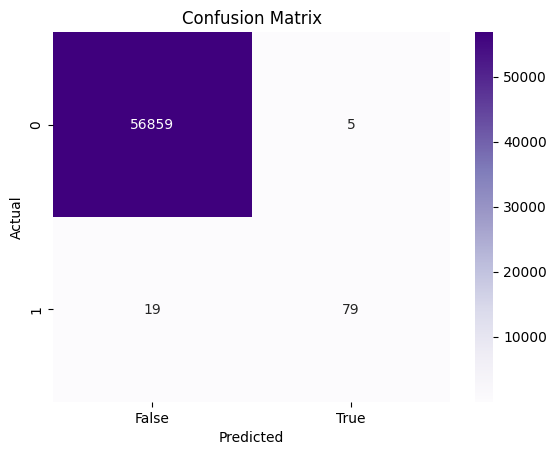

In [51]:
import seaborn as sns
confusion_matrix = pd.crosstab(y_test.values.T, y_pred.values.T, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='Purples', fmt='g')
plt.title('Confusion Matrix')
plt.savefig('ressources/plots/confusion_matrix_ml.png')